# Hydrometeor Classification

Using [CSU_RadarTools](https://github.com/CSU-RadarMet/CSU_RadarTools) package, the following polarimetric variables were extracted from FCTH Radar files:
- `'corrected_reflectivity'`
- `'cross_correlation_ratio'`
- `'differential_reflectivity'`
- `'specific_differential_phase'`
  
Hydrometeor classification were made using `csu_fhc.csu_fhc_summer` function. Ice and liquid water masses were calculated using `csu_liquid_ice_mass.calc_liquid_ice_mass` function.

## Loading necessary packages

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import read_brazil_radar as rbr
import pyart
import glob
from skewt import SkewT
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Necessary functions

### Miscellaneous

#### `add_field_to_radar_object`: transforming array into radar data

In [2]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='corrected_reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['data'].fill_value
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  'fill_value': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

#### `radar_coords_to_cart`: Converting radar to cartesian coordinates

In [3]:
def radar_coords_to_cart(rng, az, ele, debug=False):

    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z

#### `get_z_from_radar`: Calculating radar height correspondent to elevations

In [4]:
def get_z_from_radar(radar):
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']

#### `check_sounding_for_montonic`: Forcing sounding data to be monotonic

In [5]:
def check_sounding_for_montonic(sounding):
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]: #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z

#### `interpolate_sounding_to_radar`: interpolating sounding data to radar

In [6]:
def interpolate_sounding_to_radar(sounding, radar):
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

### Plotting

#### Adjusting color scale for HIDs plot

In [7]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

## Reading radar data filenames and azimuths/hailpad position for cross-sections

In [8]:
files_cth = open("data_entry/cth_level0.txt", 'r')
files_cth = files_cth.read().split('\n')

#-- [hailpad position, azimuth angle]
cs_data = [[141, 307], [135, 304], [155, 310], [140, 297], [142, 296], [141, 308]]

## Reading hailpads and sounding data

In [9]:
hailpads_pos = np.loadtxt("data_entry/hailpads_registry.txt", delimiter=',')

In [10]:
soundings = [SkewT.Sounding('../Dados/SONDAGENS/83779_2016120512Z.txt'), 
             SkewT.Sounding('../Dados/SONDAGENS/83779_2017012812Z.txt'), 
             SkewT.Sounding('../Dados/SONDAGENS/83779_2017031512Z.txt'), 
             SkewT.Sounding('../Dados/SONDAGENS/83779_2017031512Z.txt'), 
             SkewT.Sounding('../Dados/SONDAGENS/83779_2017111512Z.txt'), 
             SkewT.Sounding('../Dados/SONDAGENS/83779_2017111612Z.txt')]

## Plotting horizontal and vertical fields for each case

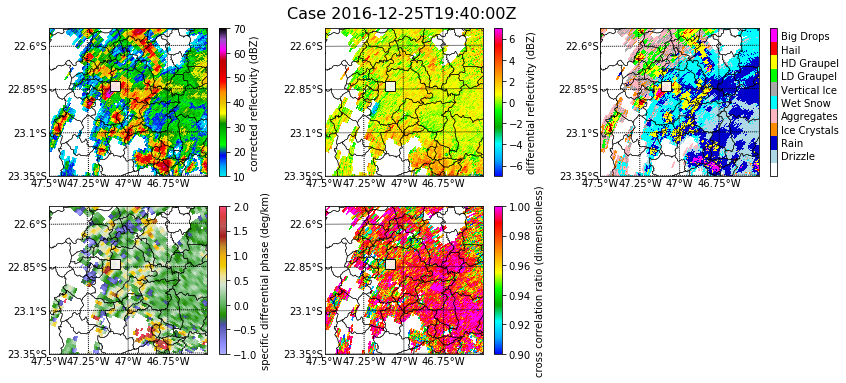

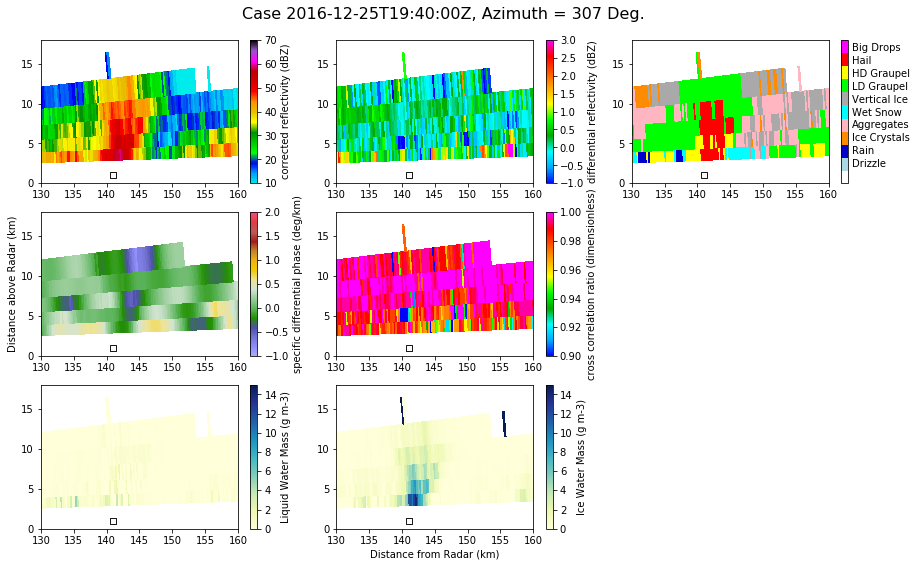

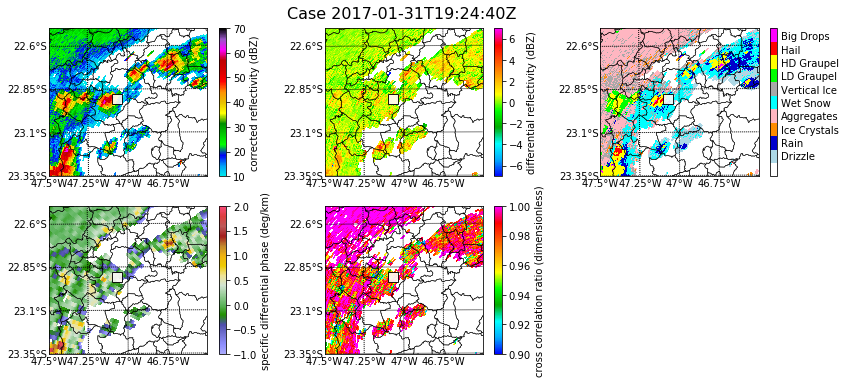

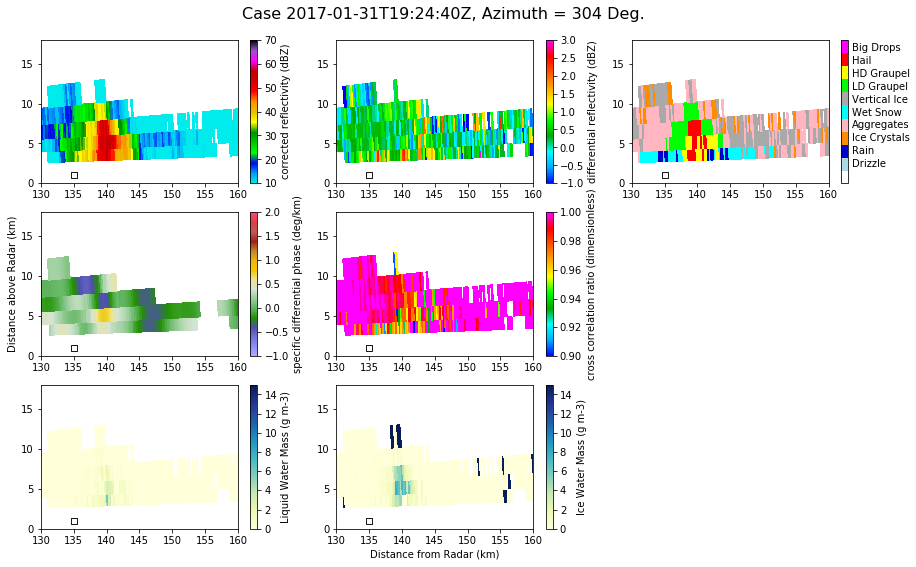

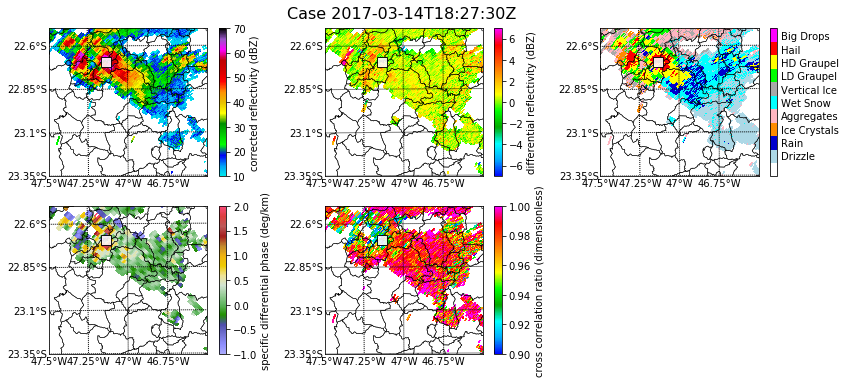

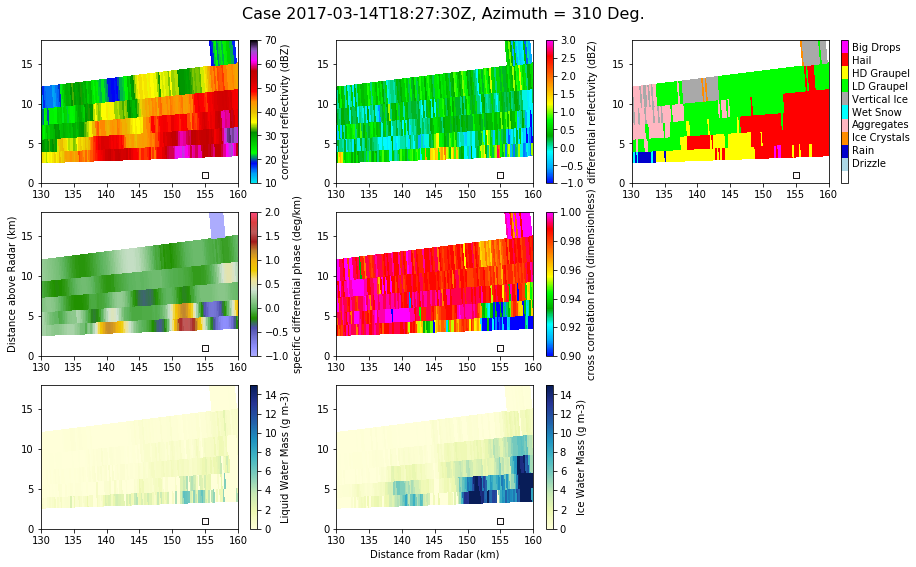

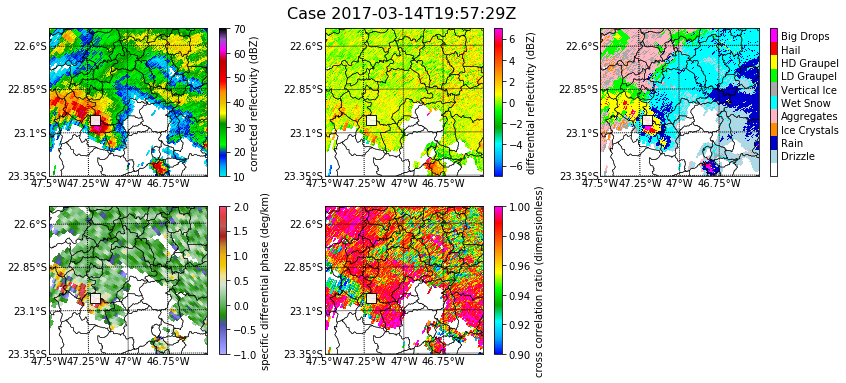

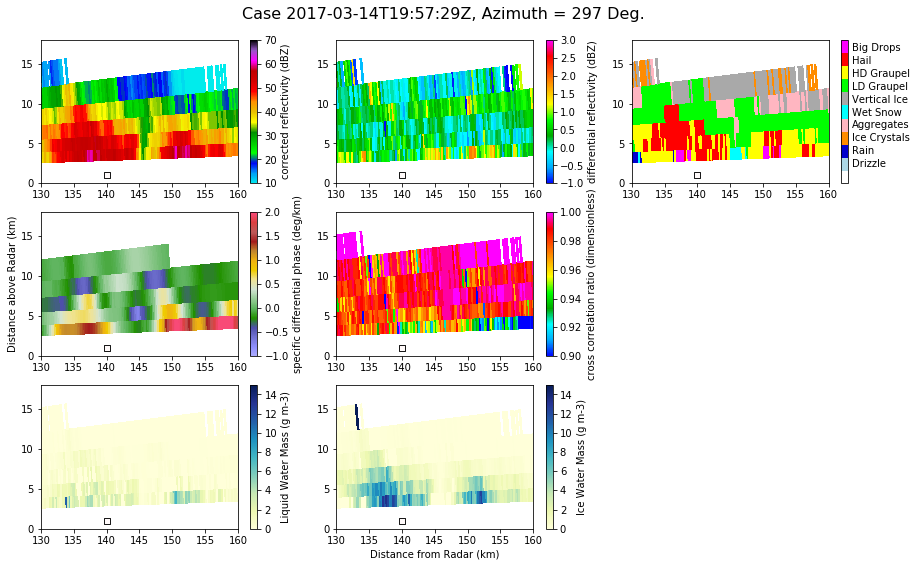

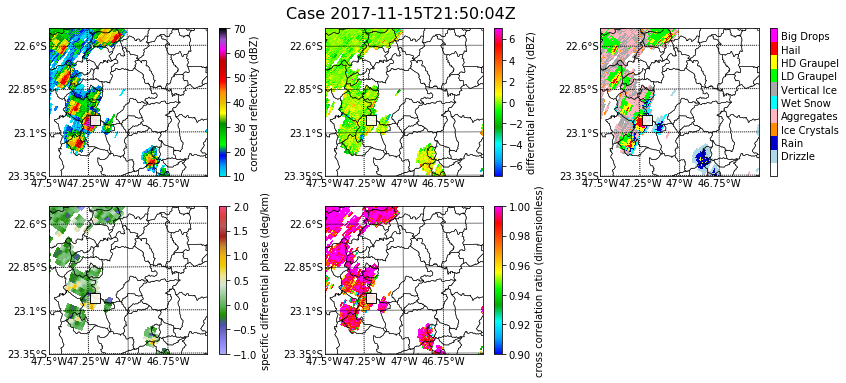

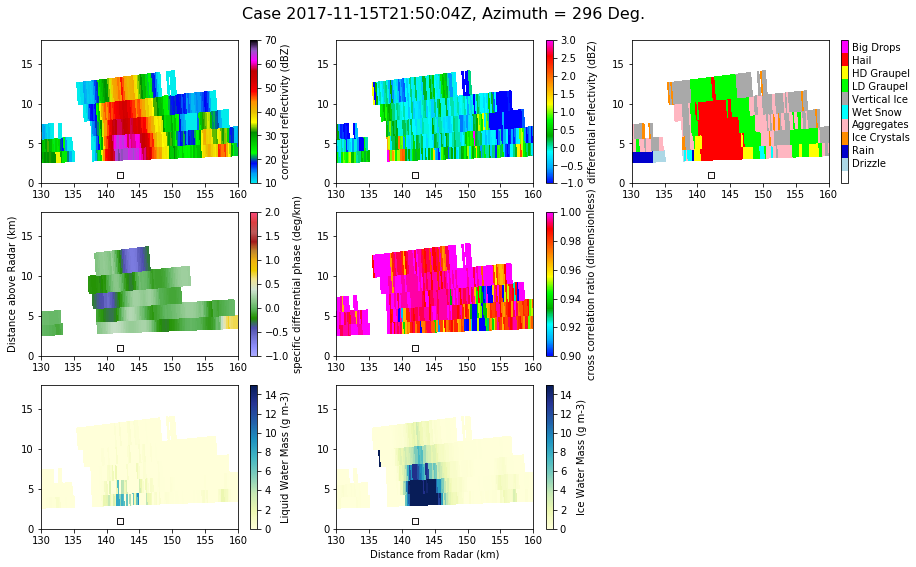

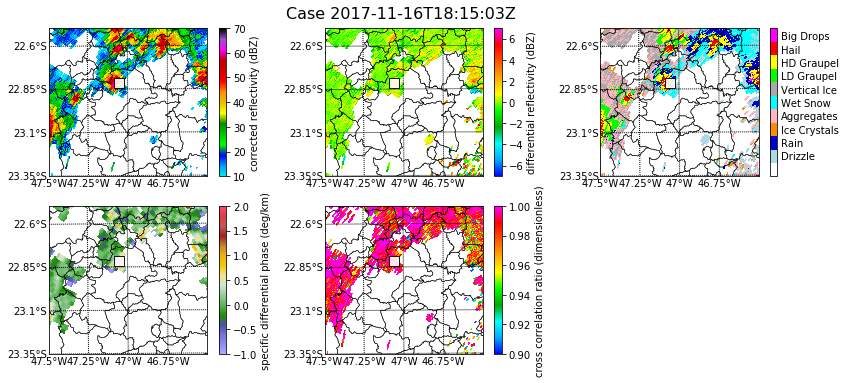

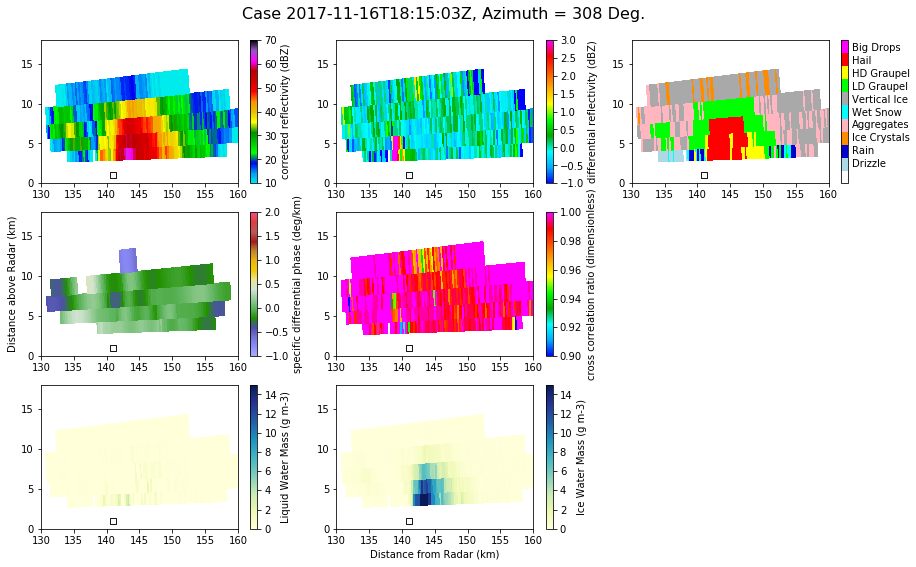

In [11]:
for i in range(0, 6):
    #-- Reading data, interpolating with sounding
    cthfile = rbr.read_rainbow_hdf5(files_cth[i])
    cthfile_T, cthfile_z = interpolate_sounding_to_radar(soundings[i], cthfile)
    #-- Extracting necessary variables
    corr_dBZ = cthfile.fields['corrected_reflectivity']['data']
    zdr = cthfile.fields['differential_reflectivity']['data']
    kdp = cthfile.fields['specific_differential_phase']['data']
    rho_hv = cthfile.fields['cross_correlation_ratio']['data']
    
    #-- Classifying
    scores = csu_fhc.csu_fhc_summer(dz=corr_dBZ, zdr=zdr, kdp=kdp, rho=rho_hv, 
                                    use_temp=True, T=cthfile_T, band='S')
    fh = np.argmax(scores, axis = 0) + 1
    #--- Adding to radar file
    cthfile = add_field_to_radar_object(fh, cthfile)
    
    #-- Calculating liquid and ice mass
    mw, mi = csu_liquid_ice_mass.calc_liquid_ice_mass(corr_dBZ, zdr, cthfile_z/1000.0, T=cthfile_T)
    #--- Adding to radar file
    cthfile = add_field_to_radar_object(mw, cthfile, field_name='MW', units='g m-3',
                                        long_name='Liquid Water Mass', standard_name='Liquid Water Mass')
    cthfile = add_field_to_radar_object(mi, cthfile, field_name='MI', units='g m-3',
                                        long_name='Ice Water Mass', standard_name='Ice Water Mass')

    #-- Plotting horizontal fields
    display = pyart.graph.RadarMapDisplay(cthfile)
    fig = plt.figure(figsize=[14,6])
    xlim, ylim = [-47.5,-46.5], [-23.35,-22.5]
    
    #--- Reflectivity
    ax = fig.add_subplot(231)
    display.plot_ppi_map('corrected_reflectivity', sweep=0, shapefile="shapefiles/sao_paulo", 
                         max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                         vmin = 10, vmax = 70, mask_outside=True, title="", 
                         lat_lines=np.arange(ylim[0], ylim[1], .25), lon_lines=np.arange(xlim[0], xlim[1], .25))
    display.plot_point(lat=hailpads_pos[i][0], lon=hailpads_pos[i][1], symbol = 'ks', #-- Hailpad
                       markersize=10, alpha=0.9, markerfacecolor='snow')
    
    #--- ZDR
    ax = fig.add_subplot(232)
    display.plot_ppi_map('differential_reflectivity', sweep=0, shapefile="shapefiles/sao_paulo", 
                         max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                         vmin = -7, vmax = 7, mask_outside=True, title="",
                         lat_lines=np.arange(ylim[0], ylim[1], .25), lon_lines=np.arange(xlim[0], xlim[1], .25))
    display.plot_point(lat=hailpads_pos[i][0], lon=hailpads_pos[i][1], symbol = 'ks', #-- Hailpad
                       markersize=10, alpha=0.9, markerfacecolor='snow')
    
    #--- Hydrometeor Classification
    ax = fig.add_subplot(233)
    display.plot_ppi_map('FH', sweep=0, shapefile="shapefiles/sao_paulo", 
                         max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                         vmin = 0, vmax = 10, mask_outside=True, title="", cmap=cmaphid, 
                         lat_lines=np.arange(ylim[0], ylim[1], .25), lon_lines=np.arange(xlim[0], xlim[1], .25))
    display.plot_point(lat=hailpads_pos[i][0], lon=hailpads_pos[i][1], symbol = 'ks', #-- Hailpad
                       markersize=10, alpha=0.9, markerfacecolor='snow')

    #--- KDP
    ax = fig.add_subplot(234)
    display.plot_ppi_map('specific_differential_phase', sweep=0, shapefile="shapefiles/sao_paulo", 
                         max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                         vmin = -1, vmax = 2, mask_outside=True, title="", 
                         lat_lines=np.arange(ylim[0], ylim[1], .25), lon_lines=np.arange(xlim[0], xlim[1], .25))
    display.plot_point(lat=hailpads_pos[i][0], lon=hailpads_pos[i][1], symbol = 'ks', #-- Hailpad
                       markersize=10, alpha=0.9, markerfacecolor='snow')

    #--- RHO
    ax = fig.add_subplot(235)
    display.plot_ppi_map('cross_correlation_ratio', sweep=0, shapefile="shapefiles/sao_paulo", 
                         max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                         vmin = 0.9, vmax = 1, mask_outside=True, title="", 
                         lat_lines=np.arange(ylim[0], ylim[1], .25), lon_lines=np.arange(xlim[0], xlim[1], .25))
    display.plot_point(lat=hailpads_pos[i][0], lon=hailpads_pos[i][1], symbol = 'ks', #-- Hailpad
                       markersize=10, alpha=0.9, markerfacecolor='snow')

    plt.suptitle("Case "+cthfile.time['units'][14:], fontsize=16, y=0.93)
    display.cbs[2] = adjust_fhc_colorbar_for_pyart(display.cbs[2])
    plt.savefig("figuras/ppis/classificacao/classh_case"+str(i)+'.png', bbox_inches='tight')
    
    #-- Selecting cross-section
    cth_cs = pyart.util.cross_section_ppi(cthfile, [cs_data[i][1]])
    
    #-- Plotting vertical fields
    display = pyart.graph.RadarDisplay(cth_cs)
    f = plt.figure(figsize=[15,9])
   
    #--- Reflectivity
    ax = f.add_subplot(331)
    display.plot('corrected_reflectivity', vmin=10, vmax=70, title='', axislabels_flag=False)
    pnt = ax.scatter(x=cs_data[i][0], y=1, marker='s', c='snow', alpha=0.9, edgecolors='black') #-- Hailpad
    plt.xlim((130,160))
    plt.ylim((0,18))

    #--- ZDR
    ax = f.add_subplot(332)
    display.plot('differential_reflectivity', vmin = -1, vmax = 3, title = '', axislabels_flag=False)
    pnt = ax.scatter(x=cs_data[i][0], y=1, marker='s', c='snow', alpha=0.9, edgecolors='black') #-- Hailpad
    plt.xlim((130,160))
    plt.ylim((0,18))

    #--- Hydrometeor Classification
    ax = f.add_subplot(333)
    display.plot('FH', vmin=0, vmax=10, cmap=cmaphid, title = '', axislabels_flag=False)
    pnt = ax.scatter(x=cs_data[i][0], y=1, marker='s', c='snow', alpha=0.9, edgecolors='black') #-- Hailpad
    plt.xlim((130,160))
    plt.ylim((0,18))
        
    #--- KDP
    ax = f.add_subplot(334)
    display.plot('specific_differential_phase', vmin = -1, vmax = 2, title = '', 
                 axislabels=('', 'Distance above Radar (km)'))
    pnt = ax.scatter(x=cs_data[i][0], y=1, marker='s', c='snow', alpha=0.9, edgecolors='black') #-- Hailpad
    plt.xlim((130,160))
    plt.ylim((0,18))
    
    #--- RHO
    ax = f.add_subplot(335)
    display.plot('cross_correlation_ratio', vmin = 0.9, vmax = 1, title = '', axislabels_flag=False)
    pnt = ax.scatter(x=cs_data[i][0], y=1, marker='s', c='snow', alpha=0.9, edgecolors='black') #-- Hailpad
    plt.xlim((130,160))
    plt.ylim((0,18))
 
    #--- Liquid Water Mass
    ax = f.add_subplot(337)
    display.plot('MW', vmin = 0, vmax = 15, cmap='YlGnBu', title = '', axislabels_flag=False)
    pnt = ax.scatter(x=cs_data[i][0], y=1, marker='s', c='snow', alpha=0.9, edgecolors='black') #-- Hailpad
    plt.xlim((130,160))
    plt.ylim((0,18))
 
    #--- Ice Water Mass
    ax = f.add_subplot(338)
    display.plot('MI', vmin = 0, vmax = 15, cmap='YlGnBu', title = '',
                axislabels=('Distance from Radar (km)', ''))
    pnt = ax.scatter(x=cs_data[i][0], y=1, marker='s', c='snow', alpha=0.9, edgecolors='black') #-- Hailpad
    plt.xlim((130,160))
    plt.ylim((0,18))
        
    plt.suptitle("Case "+cth_cs.time['units'][14:]+', Azimuth = '+str(cs_data[i][1])+' Deg. ', fontsize=16, y=0.93)
    display.cbs[2] = adjust_fhc_colorbar_for_pyart(display.cbs[2])
    plt.savefig("figuras/ppis/classificacao/classv_case"+str(i)+'.png', bbox_inches='tight')